In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from biosppy.signals import ecg
import os
import neurokit as nk
import scipy as sp


In [2]:
ecg_data_file = 'D:\data\ibeat\eplab\Subject44_data.hdf'
ecg_data = pd.read_hdf(ecg_data_file, 'eplab')

## cut ecg data

In [3]:
ecg_data = ecg_data[(ecg_data['utc_adjusted'] > 1527108380) & (ecg_data['utc_adjusted'] < 1527108473)]
ecg_data[:3]
#ecg_data.columns

,ABL,ABL Unids,ABL d,"CS 1,2","CS 3,4","CS 5,6","CS 7,8","CS 9,10",HIS d,HIS m,...,V3,V4,V5,V6,aVF,aVL,aVR,section,utc,utc_adjusted
2423794,-0.0,NaN,-0.0,0.002,0.004,-0.001,0.022,0.017,-0.020,-0.002,...,0.015,-0.060,-0.080,-0.055,-0.015,-0.083,0.022,1.0,1.527108e+09,1.527108e+09
2423795,-0.0,NaN,-0.0,0.001,0.008,0.005,0.022,0.021,-0.014,-0.003,...,0.015,-0.063,-0.080,-0.055,-0.015,-0.080,0.025,1.0,1.527108e+09,1.527108e+09
2423796,-0.0,NaN,-0.0,0.001,-0.000,0.003,0.014,0.020,-0.011,-0.008,...,0.010,-0.068,-0.083,-0.058,-0.015,-0.083,0.028,1.0,1.527108e+09,1.527108e+09


In [4]:
# Exclude the beginning of the ecg data
#ecg_data = ecg_data[(ecg_data['utc_adjusted']> 1527103410)]

## Run Biosppy ECG Analysis on chunks:

In [5]:
ecg_chunks = []
print('Analyzing {} chunks'.format(len(ecg_data.section.unique())))
for section in ecg_data.section.unique():
    ecg_section = ecg_data[ecg_data.section == section]

    # Run biosppy ecg analysis
    ecg_analysis = ecg.ecg(signal=ecg_section.II, sampling_rate=976.942, show=False)
    
    ecg_chunks.append(pd.DataFrame(dict(ecg_heart_rate=ecg_analysis['heart_rate'], 
                                        utc=ecg_analysis['heart_rate_ts'] + ecg_section.utc_adjusted.iloc[0])))

# Concatinate results
ecg_analysis = pd.concat(ecg_chunks)

Analyzing 1 chunks


C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\imapi\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index

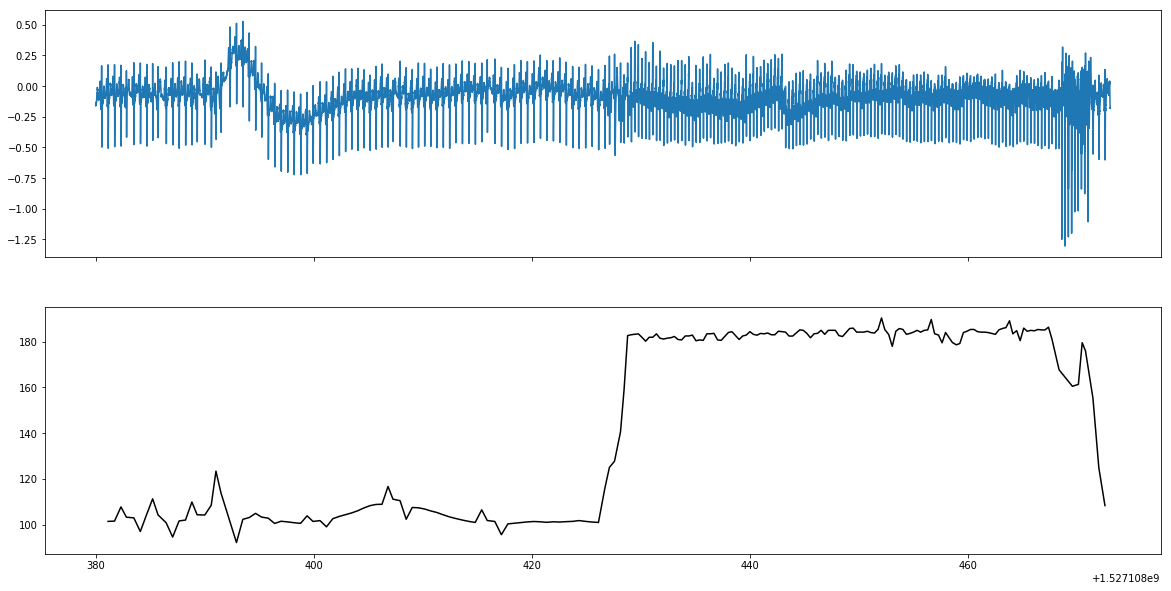

In [6]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

# Raw ECG Signal
ax[0].plot(ecg_data.utc_adjusted, ecg_data.II)

ax[1].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate, c='k', label='ECG Heart Rate')
# ax[-1].set_xlim([ecg_data.utc_adjusted.min(), ecg_data.utc_adjusted.max()])

## Baseline correction and complete the R peaks

In [7]:
SR = 976.942
ecg_sig_II = ecg_data.II
out = ecg.ecg(signal=ecg_sig_II, sampling_rate=SR,show = False)
ecg_sig_II = out['filtered']

ecg_sig_V6 = ecg_data.V6
out_V6 = ecg.ecg(signal=ecg_sig_V6, sampling_rate=SR,show = False)
ecg_sig_V6 = out_V6['filtered']


In [8]:
# plt.figure(figsize=(20,10))
# plt.plot(ecg_sig_V6)
# plt.title('Baseline corrected ECG signal')

## Two ways to find the indexes of R peaks: neurokit.py & biosppy.py

In [9]:
rpeaks2 = out['rpeaks']

In [10]:
rpeaks2[:20]

array([  531,  1110,  1686,  2263,  2752,  3416,  3998,  4573,  5101,
        5586,  6311,  6893,  7467,  8042,  8617,  9083,  9771, 10348,
       10771, 11222])

## Calculate and visualize RR intervals

In [11]:
rrinterval = []
for i in range(len(rpeaks2)-1):
    rrinterval.append((rpeaks2[i+1]-rpeaks2[i])/SR)

rrinterval[:5]

[0.5926656853733384,
 0.5895948787133729,
 0.5906184809333614,
 0.500541485574374,
 0.6796718740723605]

In [12]:
# hr = []
# for i in range(len(rrinterval)):
#     hr.append(60/rrinterval[i])
# hr[0:5]

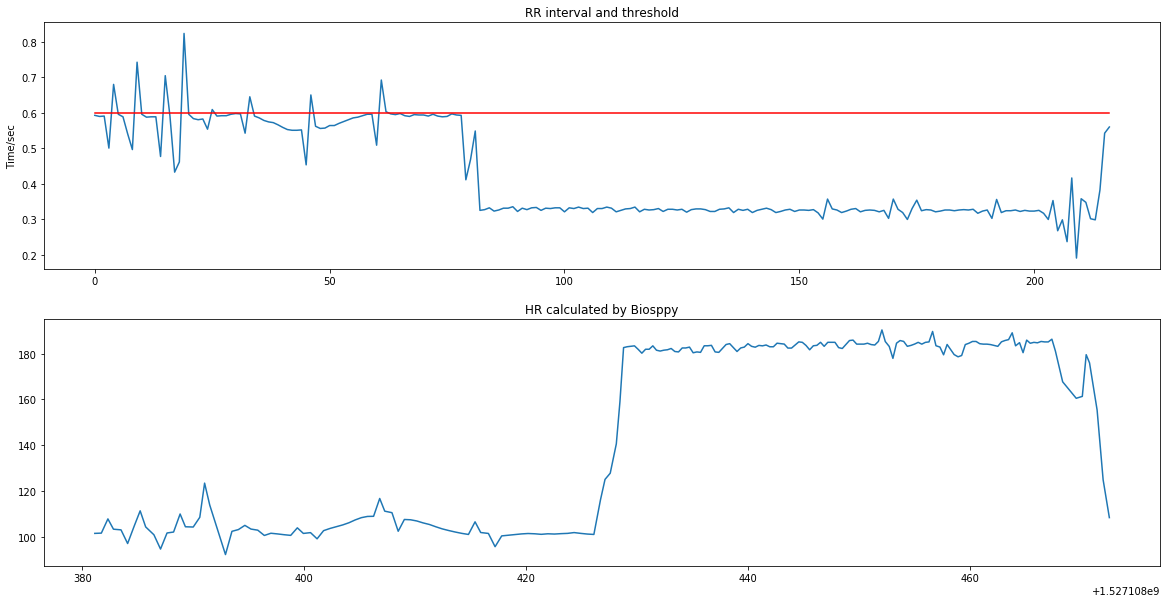

In [13]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(20, 10))
threshold = [0.6] * len(rrinterval)
# Raw ECG Signal
ax[0].plot(rrinterval)
ax[0].plot(threshold, c='r')
ax[0].set_title('RR interval and threshold')
ax[0].set_ylabel('Time/sec')
ax[1].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate)
ax[1].set_title('HR calculated by Biosppy')
plt.rcParams['axes.grid'] = False

## 5 consecutive beats of which the RR intervals are below 600ms

In [14]:
# Extract 5 consecutive RR intervals shorter than 600ms.
# Note: 5 RR intervals = 6 beats when calling rpeaks data
thold_num = 5
index = []
for i in range(len(rrinterval)-thold_num):
    if rrinterval[i] < 0.6 and rrinterval[i+1] < 0.6 and rrinterval[i+2] < 0.6 and rrinterval[i+3] < 0.6 and rrinterval[i+4] < 0.6:
        index.append(i)
index[0:10]

[10, 20, 26, 27, 28, 34, 35, 36, 37, 38]

## Group the indices into different tachycardia events

In [15]:
import more_itertools as mit
grouped_index = [list(group) for group in mit.consecutive_groups(index)]
#grouped_index[0:5]
print(len(grouped_index) , 'tachycardia events extracted')

6 tachycardia events extracted


## Find the beginning and end point of tachycardia
### Note that these indices are positions in the variable {rpeaks2}

In [16]:
begin_index = []
end_index = []
for i in range(len(grouped_index)):
    begin_index.append(grouped_index[i][0])
    end_index.append(grouped_index[i][-1] + thold_num)
    
begin_index[:5]

[10, 20, 26, 34, 47]

In [17]:
for i in begin_index:
    print(rpeaks2[i])

6311
12026
15450
20092
27258
36332


In [18]:
for i in end_index:
    print(rpeaks2[i])

9083
14855
19462
26623
35067
89836


##  Plot tachycardia strips.

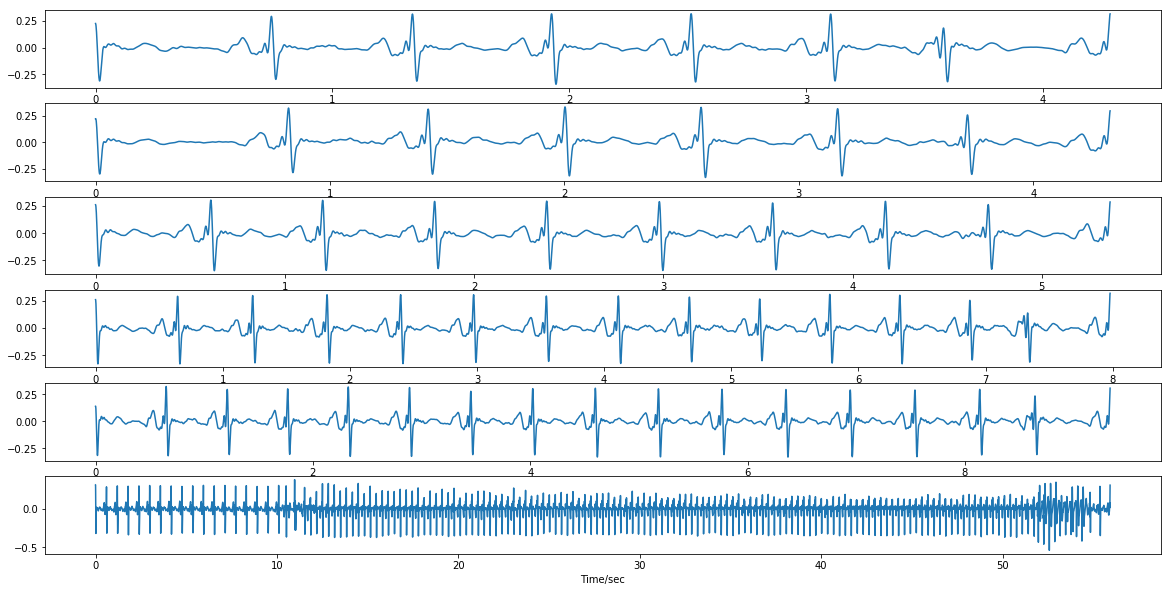

In [19]:

fig, ax = plt.subplots(len(begin_index), 1, sharex=False, figsize=(20, 10))


for i in range(len(begin_index)):
    # Use locals() function to set variable names as tachy1, tachy2, ...
    name = 'tachy'+str(i)
    
    # Note that the ith RRinterval is calculated by (i+1)th rpeak minus the ith rpeak.
    locals()['tachy'+str(i)] = ecg_sig_II[rpeaks2[begin_index[i]-1]:rpeaks2[end_index[i]+1]]
    
    # Convert the x axis from index to real time
    locals()['time'+str(i)] = np.linspace(0,(rpeaks2[end_index[i]+1] - rpeaks2[begin_index[i]-1])/SR, num = rpeaks2[end_index[i]+1] - rpeaks2[begin_index[i]-1])
    
    ax[i].plot(locals()['time'+str(i)], locals()['tachy'+str(i)])
    
    # Set x-axis as a 0.2sec grid will increase running time significantly
#    ax[i].set_xticks(np.arange(0,(rpeaks2[end_index[i]+1] - rpeaks2[begin_index[i]-1])/SR,0.2))

    plt.xlabel('Time/sec')
    plt.rcParams['axes.grid'] = True
   
    # Save subplots to subplot{}.png -- https://stackoverflow.com/questions/51429288/save-subplots-after-imshow-in-matplotlib
#     bbox = ax[i].get_tightbbox(fig.canvas.get_renderer())
#     fig.savefig("D:/data/ECG Strips/44/subplot{}.png".format(i),
#               bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))  
    # Cut the subplots into proper sizes.

## Plot the tachycardia beginning strip .

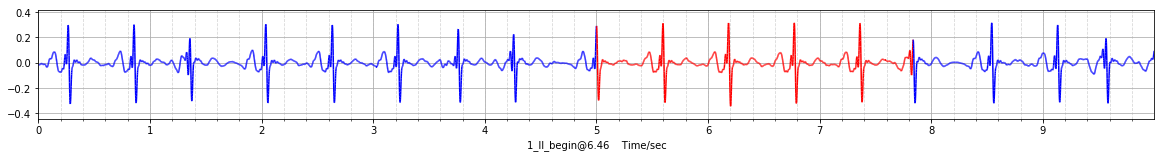

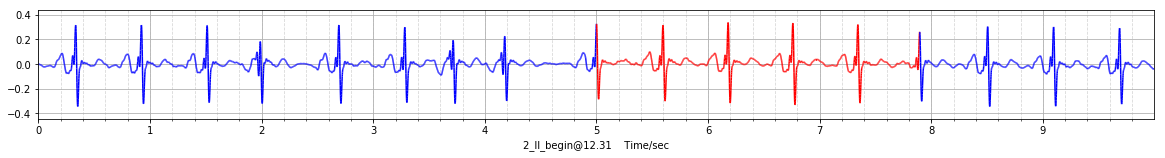

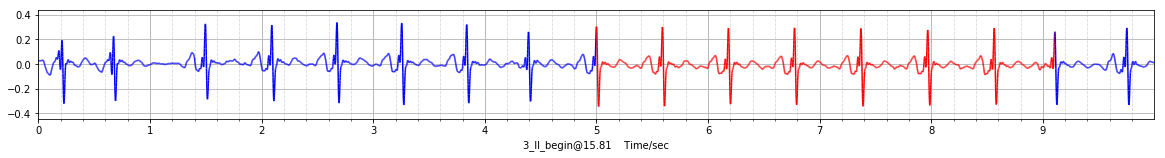

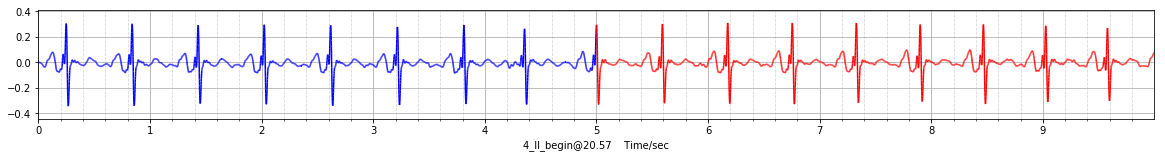

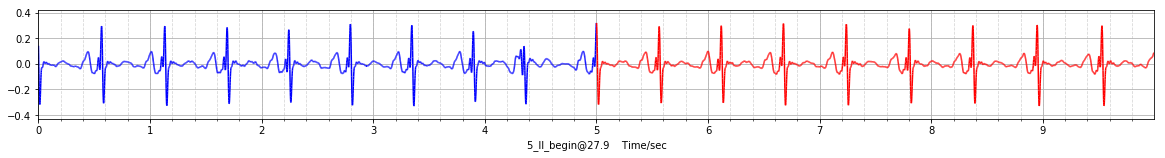

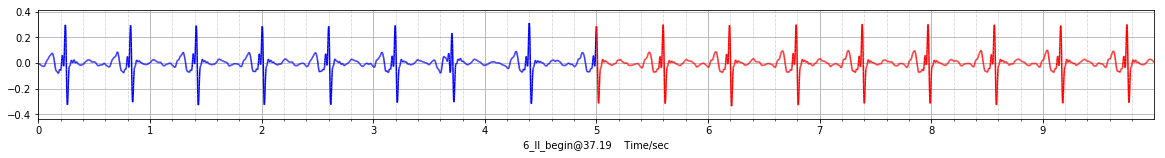

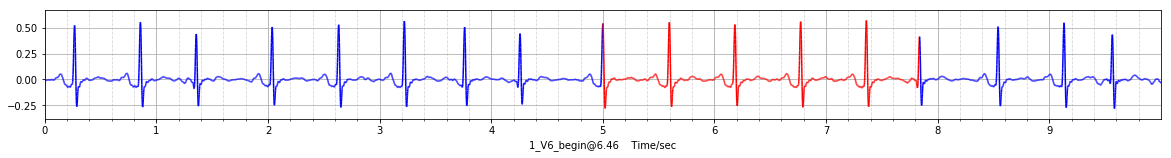

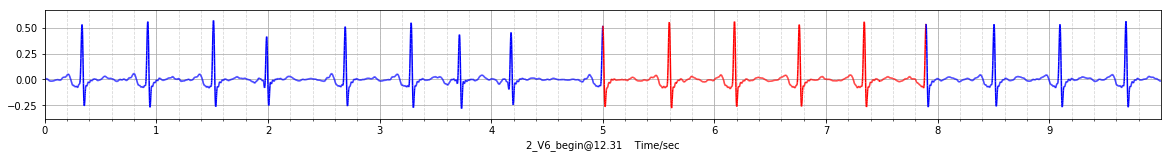

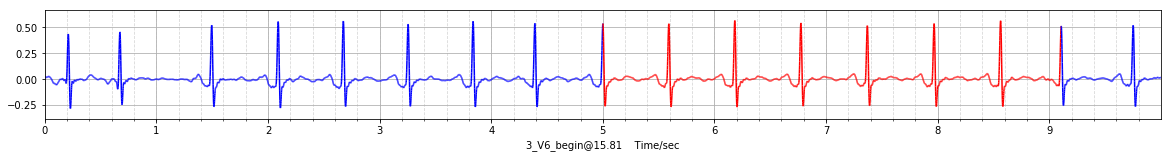

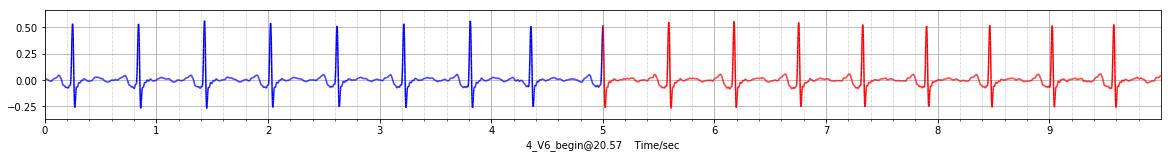

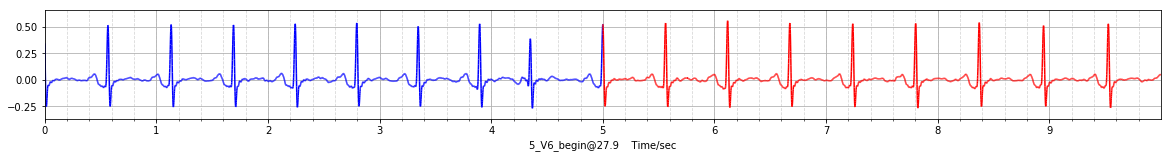

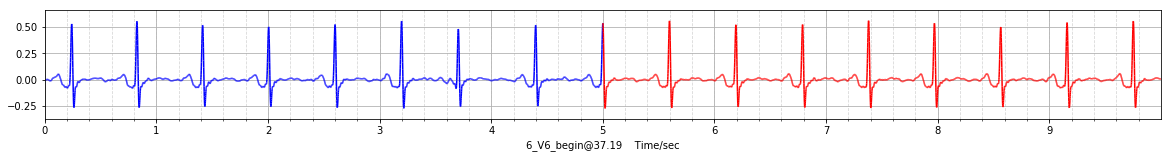

In [27]:
ecg_sig = {'II':ecg_sig_II,'V6':ecg_sig_V6}

major_ticks = np.arange(0, 10, 1)
minor_ticks = np.arange(0, 10, 0.2)

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

for sig in ecg_sig:
    
    for i in range(len(begin_index)):
    
    # To plot same line with different colors. https://matplotlib.org/1.4.1/examples/pylab_examples/multicolored_line.html
    # Use locals() function to set variable names iteratively, such as: tachy_begin1, tachy_begin2, ...
    # https://docs.python.org/3/library/functions.html#locals
    # Note that the ith RRinterval is calculated by (i+1)th rpeak minus the ith rpeak.
    # Tachycardia initiates at 5sec location.
        
        locals()['tachy_begin'+str(i)] = ecg_sig[sig][(rpeaks2[begin_index[i]] - round(5*SR)):(rpeaks2[begin_index[i]] + round(5*SR))]

        t = np.linspace(0,10,num = round(10*SR) + 1)
        cmap = ListedColormap(['b', 'r', 'b'])

        locals()['color_cutpoint'+str(i)] = (rpeaks2[end_index[i]] - rpeaks2[begin_index[i]])/SR + 5
        locals()['norm'+str(i)] = BoundaryNorm([0, 5, locals()['color_cutpoint'+str(i)], 10], cmap.N)
        locals()['points'+str(i)] = np.array([t, locals()['tachy_begin'+str(i)]]).T.reshape(-1, 1, 2)
        locals()['segments'+str(i)] = np.concatenate([locals()['points'+str(i)][:-1], locals()['points'+str(i)][1:]], axis=1)

        locals()['lc'+str(i)] = LineCollection(locals()['segments'+str(i)], cmap=cmap, norm=locals()['norm'+str(i)])
        locals()['lc'+str(i)].set_array(t)

        locals()['fig'+str(i)] = plt.figure(figsize = (20,2))
        locals()['fig'+str(i)].gca().add_collection(locals()['lc'+str(i)])         # GetCurrentAxis

        locals()['ax'+str(i)] = locals()['fig'+str(i)].add_subplot(1, 1, 1)

        locals()['ax'+str(i)].set_xticks(major_ticks)
        locals()['ax'+str(i)].set_xticks(minor_ticks, minor=True)
        locals()['ax'+str(i)].grid(which='minor', alpha=0.5, linestyle='--')
        locals()['ax'+str(i)].grid(which='major', alpha=1, linestyle='-')

        plt.ylim(min(locals()['tachy_begin'+str(i)])-0.1, max(locals()['tachy_begin'+str(i)])+0.1)    
        plt.xlim(0,10)
        plt.xlabel('{}_{}_begin@{}'.format(i+1, sig, round(rpeaks2[begin_index[i]]/SR, 2)) + '    Time/sec')

    #Save subplots to *.png
        locals()['bbox'+str(i)] = locals()['ax'+str(i)].get_tightbbox(fig.canvas.get_renderer())
        locals()['fig'+str(i)].savefig("D:/data/ECG Strips/44_{}_{}_begin@{}.png".format(i+1, sig, round(rpeaks2[begin_index[i]]/SR, 2)),
                  bbox_inches=locals()['bbox'+str(i)].transformed(locals()['fig'+str(i)].dpi_scale_trans.inverted()))  
    ## Cut the subplots into proper sizes.
    

## Plot the tachycardia ending strip.

In [22]:
#     if locals()['color_cutpoint'+str(i)] > 0:
#         cmap = ListedColormap(['b', 'r', 'b'])
#         locals()['norm'+str(i)] = BoundaryNorm([0, locals()['color_cutpoint'+str(i)], 5, 10], cmap.N)
#     else:
#         cmap = ListedColormap(['r', 'b'])
#         locals()['norm'+str(i)] = BoundaryNorm([0, 5, 10], cmap.N)

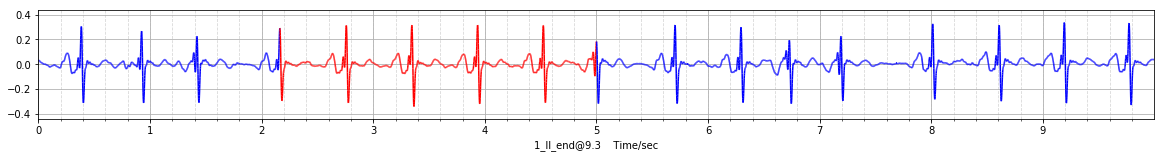

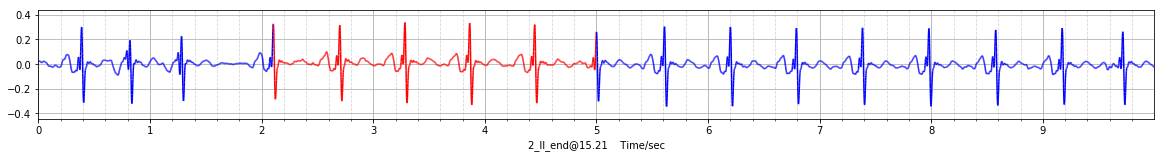

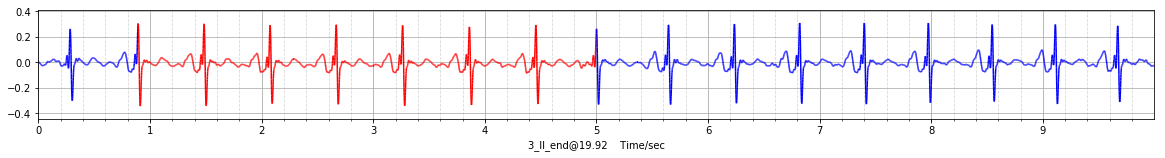

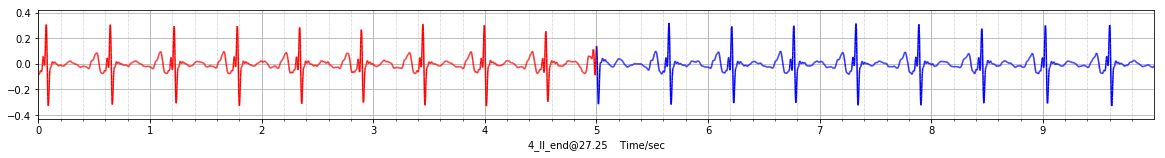

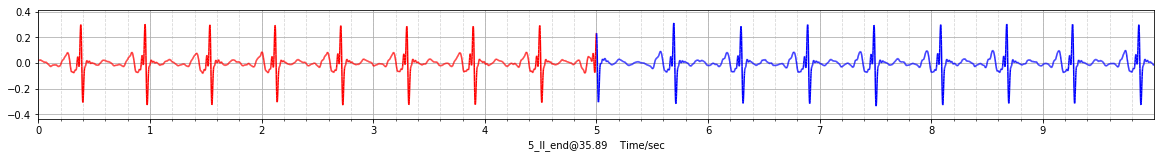

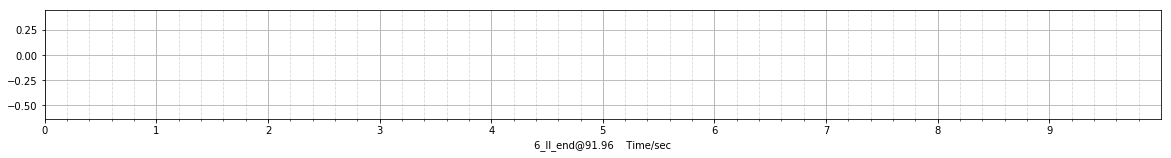

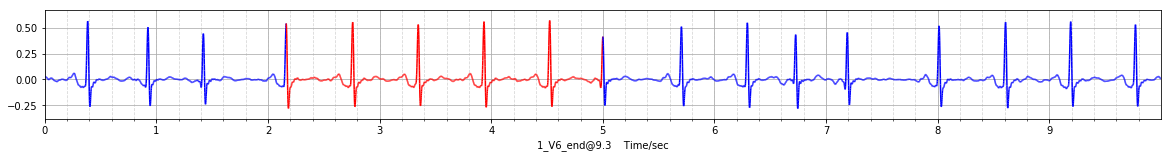

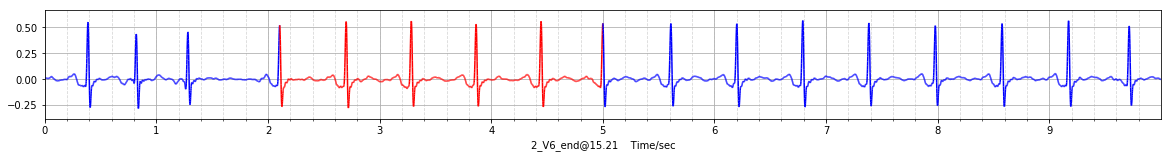

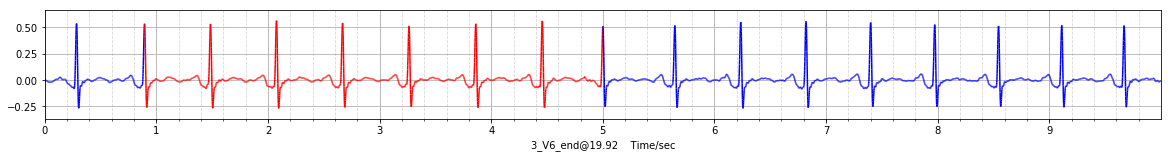

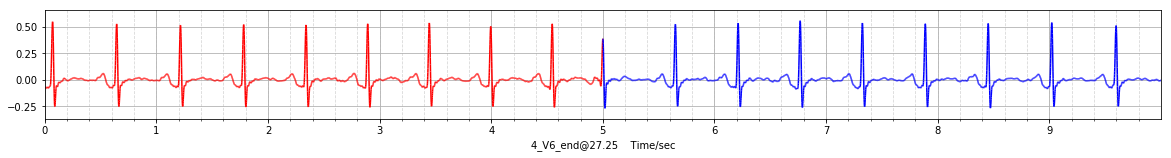

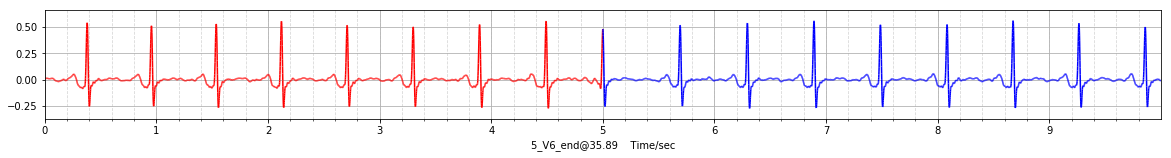

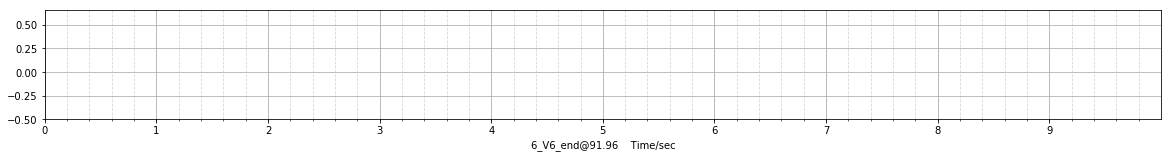

In [28]:
major_ticks = np.arange(0, 10, 1)
minor_ticks = np.arange(0, 10, 0.2)
ecg_sig = {'II':ecg_sig_II,'V6':ecg_sig_V6}

for sig in ecg_sig:
    
    for i in range(len(begin_index)):

        locals()['tachy_end'+str(i)] = ecg_sig[sig][(rpeaks2[end_index[i]] - round(5*SR)):(rpeaks2[end_index[i]] + round(5*SR))]

        t = np.linspace(0,10,num = round(10*SR) + 1)

        locals()['color_cutpoint'+str(i)] = 5 - (rpeaks2[end_index[i]] - rpeaks2[begin_index[i]])/SR 

        cmap = ListedColormap(['b', 'r', 'b'])
        locals()['norm'+str(i)] = BoundaryNorm([0, locals()['color_cutpoint'+str(i)], 5, 10], cmap.N)

        locals()['points'+str(i)] = np.array([t, locals()['tachy_end'+str(i)]]).T.reshape(-1, 1, 2)
        locals()['segments'+str(i)] = np.concatenate([locals()['points'+str(i)][:-1], locals()['points'+str(i)][1:]], axis=1)

        locals()['lc'+str(i)] = LineCollection(locals()['segments'+str(i)], cmap=cmap, norm=locals()['norm'+str(i)])
        locals()['lc'+str(i)].set_array(t)

        locals()['fig'+str(i)] = plt.figure(figsize = (20,2))
        locals()['ax'+str(i)] = locals()['fig'+str(i)].add_subplot(1, 1, 1)

        locals()['fig'+str(i)].gca().add_collection(locals()['lc'+str(i)])

        locals()['ax'+str(i)].set_xticks(major_ticks)
        locals()['ax'+str(i)].set_xticks(minor_ticks, minor=True)
        locals()['ax'+str(i)].grid(which='minor', alpha=0.5, linestyle='--')
        locals()['ax'+str(i)].grid(which='major', alpha=1, linestyle='-')

        plt.ylim(min(locals()['tachy_end'+str(i)])-0.1, max(locals()['tachy_end'+str(i)])+0.1)     
        plt.xlim(0,10)
        plt.xlabel('{}_{}_end@{}'.format(i+1, sig, round(rpeaks2[end_index[i]]/SR, 2)) + '    Time/sec')

        
        locals()['bbox'+str(i)] = locals()['ax'+str(i)].get_tightbbox(fig.canvas.get_renderer())
        locals()['fig'+str(i)].savefig("D:/data/ECG Strips/44_{}_{}_end@{}.png".format(i+1, sig, round(rpeaks2[end_index[i]]/SR, 2)),
                  bbox_inches=locals()['bbox'+str(i)].transformed(locals()['fig'+str(i)].dpi_scale_trans.inverted()))

    

## RR interval for entire episode of the arrhythmia.

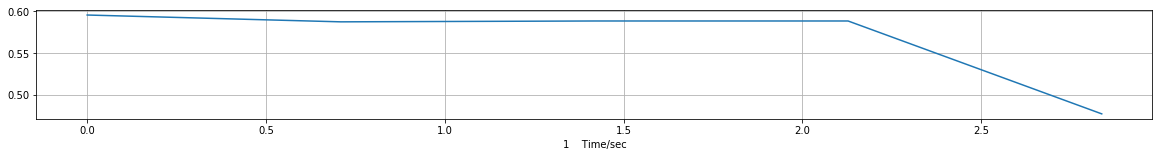

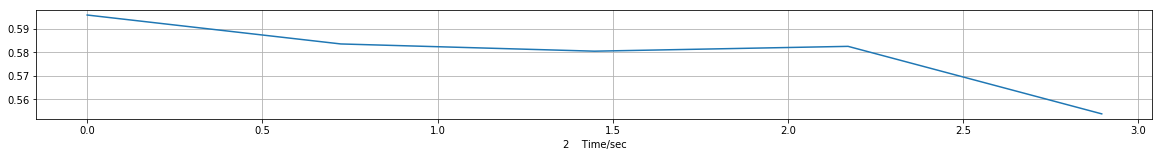

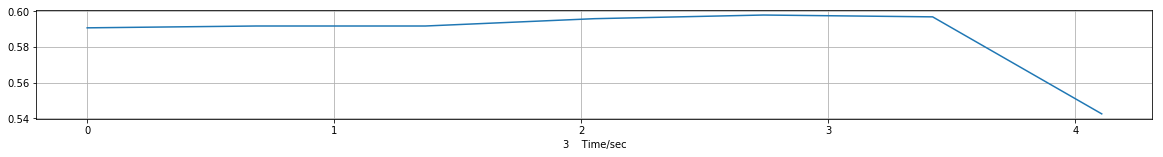

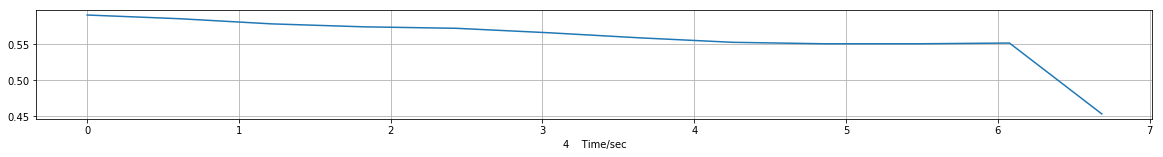

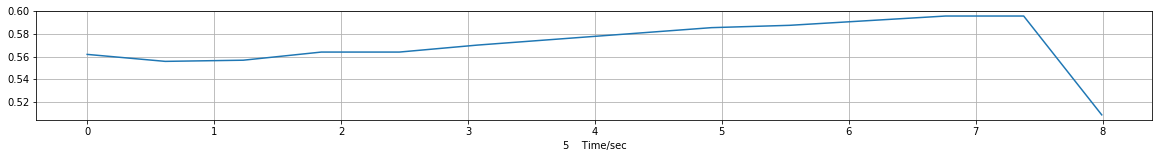

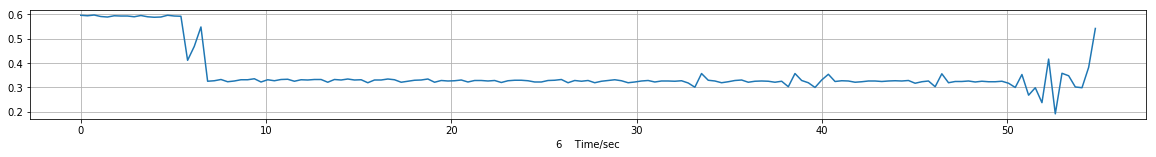

In [30]:
# fig, ax = plt.subplots(len(begin_index), 1, sharex=False, figsize=(20, 10))
for i in range(len(begin_index)):
    locals()['rr'+str(i)] = []
    locals()['rr'+str(i)].append(rrinterval[begin_index[i]:end_index[i]])
    
    locals()['time'+str(i)] = (rpeaks2[end_index[i]] - rpeaks2[begin_index[i]])/SR
    
    locals()['t'+str(i)] = np.linspace(0,locals()['time'+str(i)], num = len(locals()['rr'+str(i)][0]))
    
    locals()['fig'+str(i)] = plt.figure(figsize = (20,2))
    locals()['ax'+str(i)] = locals()['fig'+str(i)].add_subplot(1, 1, 1)
    
    locals()['ax'+str(i)].plot(locals()['t'+str(i)] , locals()['rr'+str(i)][0])
    
#     ax[i].plot(locals()['t'+str(i)] , locals()['rr'+str(i)][0])
    plt.xlabel('{}'.format(i+1) + '    Time/sec')
    
    locals()['bbox'+str(i)] = locals()['ax'+str(i)].get_tightbbox(fig.canvas.get_renderer())
    locals()['fig'+str(i)].savefig("D:/data/ECG Strips/44_{}_RRinterval.png".format(i+1),
              bbox_inches=locals()['bbox'+str(i)].transformed(locals()['fig'+str(i)].dpi_scale_trans.inverted()))

## Plot the middle strip. (the fastest HR beat is at 5 sec)

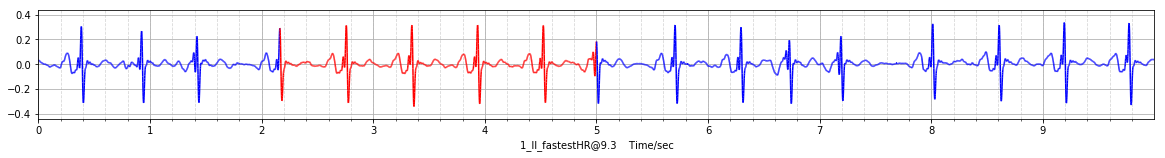

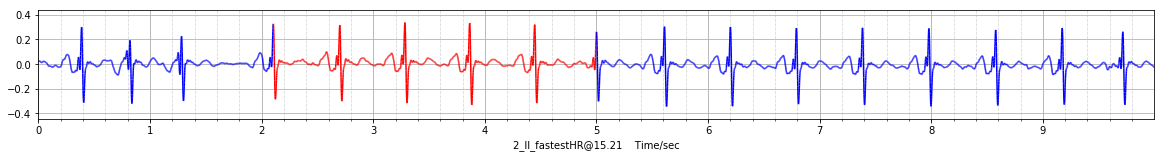

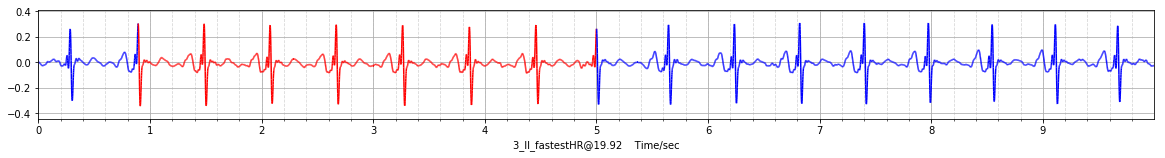

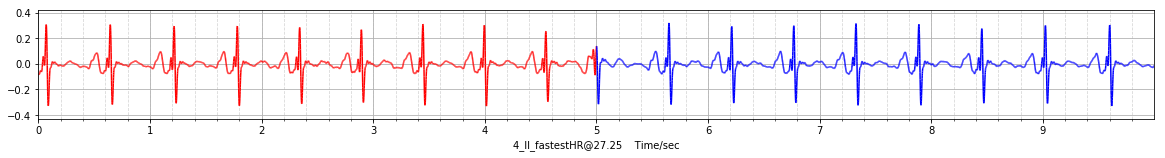

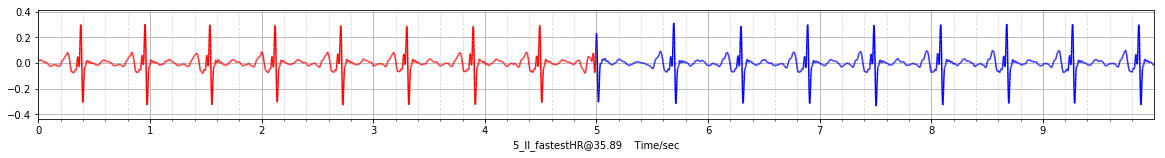

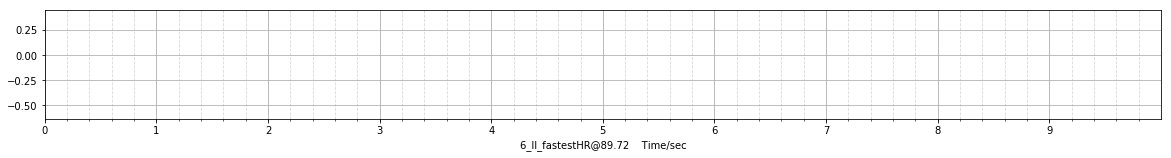

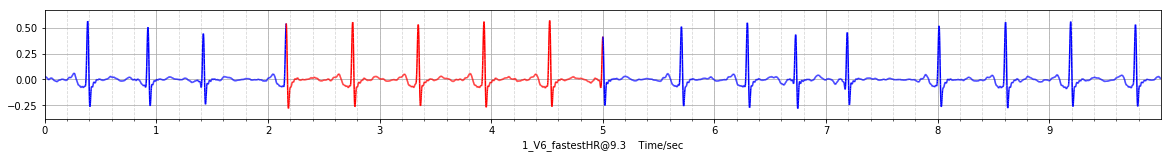

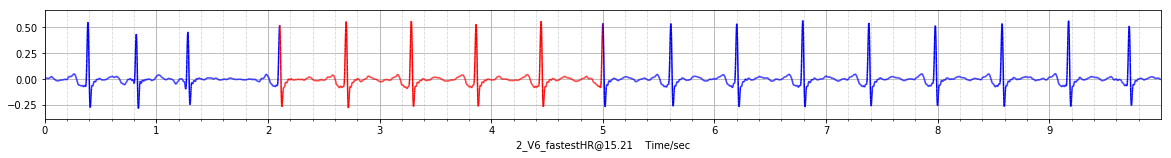

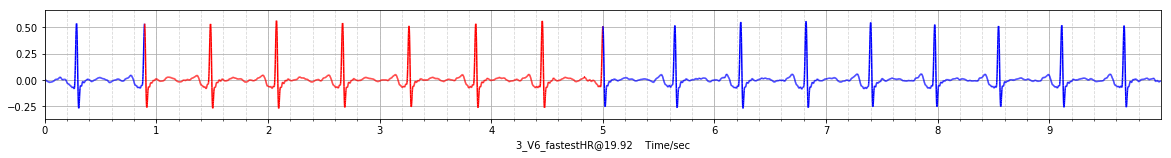

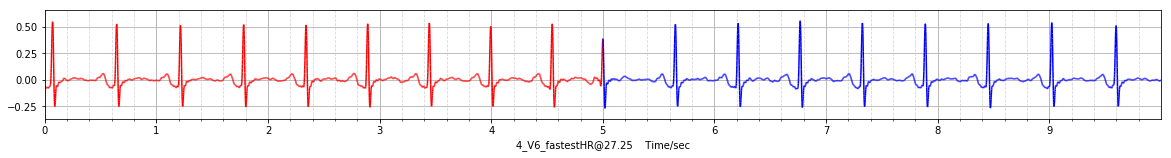

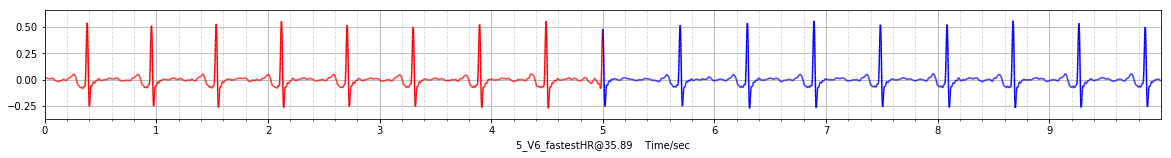

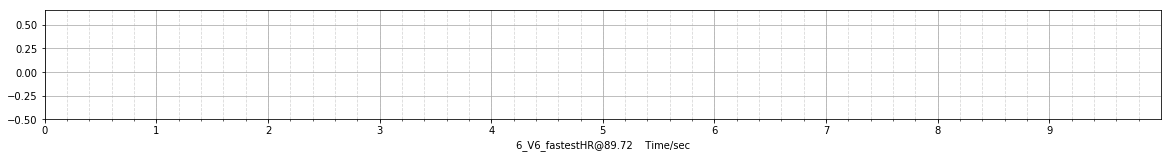

In [32]:

min_index = []
# minimum RR interval after tachycardia begins, begin_index[i] + min_index[i] + 1

for sig in ecg_sig:

    for i in range(len(begin_index)):

        min_index.append(np.argmin(locals()['rr'+str(i)])) 
        t = np.linspace(0,10,num = round(10*SR) + 1)

        locals()['tachy_mid'+str(i)] = ecg_sig[sig][(rpeaks2[begin_index[i] + min_index[i] + 1] - round(5*SR)):(rpeaks2[begin_index[i] + min_index[i] + 1] + round(5*SR))]

        locals()['left_cutpoint'+str(i)] = 5 - (rpeaks2[begin_index[i] + min_index[i] + 1] - rpeaks2[begin_index[i]])/SR 
        locals()['right_cutpoint'+str(i)] = (rpeaks2[end_index[i]] - rpeaks2[begin_index[i] + min_index[i] + 1])/SR + 5

        #ax[i].plot(t, locals()['tachy_mid'+str(i)])

        cmap = ListedColormap(['b', 'r', 'b'])
        locals()['norm'+str(i)] = BoundaryNorm([0, locals()['left_cutpoint'+str(i)], locals()['right_cutpoint'+str(i)], 10], cmap.N)

        locals()['points'+str(i)] = np.array([t, locals()['tachy_mid'+str(i)]]).T.reshape(-1, 1, 2)
        locals()['segments'+str(i)] = np.concatenate([locals()['points'+str(i)][:-1], locals()['points'+str(i)][1:]], axis=1)

        locals()['lc'+str(i)] = LineCollection(locals()['segments'+str(i)], cmap=cmap, norm=locals()['norm'+str(i)])
        locals()['lc'+str(i)].set_array(t)

        locals()['fig'+str(i)] = plt.figure(figsize = (20,2))
        locals()['ax'+str(i)] = locals()['fig'+str(i)].add_subplot(1, 1, 1)

        locals()['fig'+str(i)].gca().add_collection(locals()['lc'+str(i)])

        locals()['ax'+str(i)].set_xticks(major_ticks)
        locals()['ax'+str(i)].set_xticks(minor_ticks, minor=True)
        locals()['ax'+str(i)].grid(which='minor', alpha=0.5, linestyle='--')
        locals()['ax'+str(i)].grid(which='major', alpha=1, linestyle='-')

        plt.ylim(min(locals()['tachy_mid'+str(i)])-0.1, max(locals()['tachy_mid'+str(i)])+0.1)    
        plt.xlim(0,10)
        plt.xlabel('{}_{}_fastestHR@{}'.format(i+1, sig, round(rpeaks2[begin_index[i] + min_index[i] + 1]/SR, 2)) + '    Time/sec')

        #Save subplots to png, 
        locals()['bbox'+str(i)] = locals()['ax'+str(i)].get_tightbbox(fig.canvas.get_renderer())
        locals()['fig'+str(i)].savefig("D:/data/ECG Strips/44_{}_{}_fastestHR@{}.png".format(i+1, sig, round(rpeaks2[begin_index[i] + min_index[i] + 1]/SR, 2)),
                  bbox_inches=locals()['bbox'+str(i)].transformed(locals()['fig'+str(i)].dpi_scale_trans.inverted()))


## Proportion of time that labeled as tachycardia

In [26]:
# The begin_index and end_index should be calculated from whole data(no cut): proportion = 39.7%
begin_time = []
end_time = []
for i in begin_index:
    begin_time.append(rpeaks2[i])
for i in end_index:
    end_time.append(rpeaks2[i])
time = sum(end_time) - sum(begin_time)
proportion = time/len(ecg_data)
proportion

0.8525342578834406

## Next steps:
1. Plot V6 lead as well. (II lead now)
2. Apply the code to all the ECG signal. (too much data, RAM overflow 1. Downsample; 2. Cut the data into chunks.)
3. In batch, save & upload the subplots to labelbox.com. (requires proper naming of subplots)